# Credit Card Transactions Fraud Detection


**Data Link:** https://www.kaggle.com/datasets/kartik2112/fraud-detection/data

The dataset includes credit card transactions that were created using Sparkov simulations for a sample of 1000 customers who made purchases from 800 businesses between January 2019 and December 2020. It includes both legitimate transactions as well as fraudulent transactions.

It includes transaction details, merchant details, and customer demographic details. The target variable is a binary indication that determines whether the transaction is fraudulent or not.

**Importing Libraries**

In [27]:
#!pip install follium
#!pip install geopy
#!pip install imbalanced-learn
#!pip install --upgrade scikit-learn imbalanced-learn

In [28]:
# importing libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy.stats import ttest_ind
from geopy.distance import geodesic
from imblearn.under_sampling import RandomUnderSampler,TomekLinks,EditedNearestNeighbours,CondensedNearestNeighbour,ClusterCentroids
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

**Data Loading**

In [29]:
# loading datasets
train = pd.read_csv('datasets/fraudTrain.csv',index_col=0)
test = pd.read_csv('datasets/fraudTest.csv',index_col=0)
# print the shape of data
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Train data shape: (1296675, 22)
Test data shape: (555719, 22)


In [30]:
# merging train and test data
fraud = pd.concat([train, test], ignore_index=True)
# print the shape of data
print(f"Data shape: {fraud.shape}\n")
# print basic info of data
print(fraud.info())

Data shape: (1852394, 22)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int6

In [31]:
# looking at first few rows of the data
fraud.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


**Missing Values Check**

In [32]:
# checking for missing values
print(fraud.isnull().sum())

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


**Duplicates handling**

In [33]:
# removing duplicates
fraud.drop_duplicates(inplace=True)
fraud.reset_index(drop=True, inplace=True)

In [34]:
print(f"Size after handling duplicates: {fraud.shape}")

Size after handling duplicates: (1852394, 22)


So no duplicates in data!

**DataType Updates**

In [35]:
# Convert columns to 'datetime'
fraud['trans_date_trans_time'] = pd.to_datetime(fraud['trans_date_trans_time'])
fraud['dob'] = pd.to_datetime(fraud['dob'])

In [36]:
# Convert 'is_fraud' to boolean 
fraud['is_fraud'] = fraud['is_fraud'].astype(bool)

**Initial EDA**

In [37]:
print(fraud['is_fraud'].value_counts())

is_fraud
False    1842743
True        9651
Name: count, dtype: int64


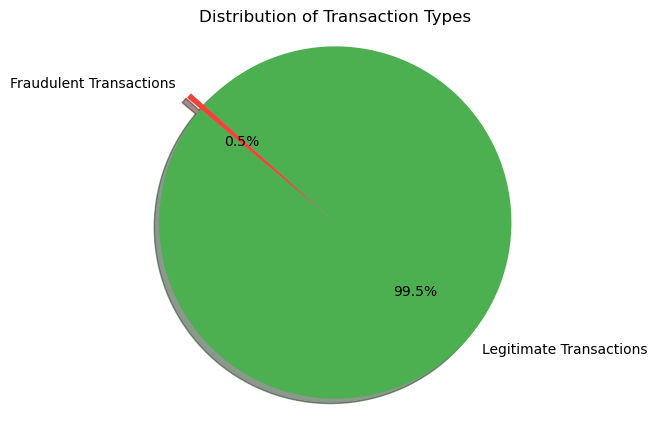

In [38]:
import matplotlib.pyplot as plt

# Data for plotting
labels = 'Legitimate Transactions', 'Fraudulent Transactions'
sizes = [1842743, 9651]
colors = ['#4CAF50', '#F44336']
explode = (0, 0.1)  # explode the 2nd slice (i.e., 'Fraud')

# Plot
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Distribution of Transaction Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


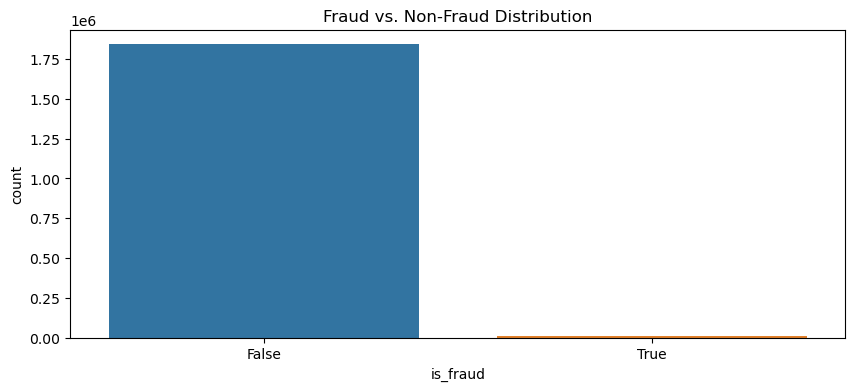

In [39]:
# Fraud vs. non-fraud distribution
plt.figure(figsize=(10, 4))
sns.countplot(x='is_fraud', data=fraud)
plt.title('Fraud vs. Non-Fraud Distribution')
plt.show()

In [40]:
# merchant unique values
print(len(fraud['merchant'].unique()))

693


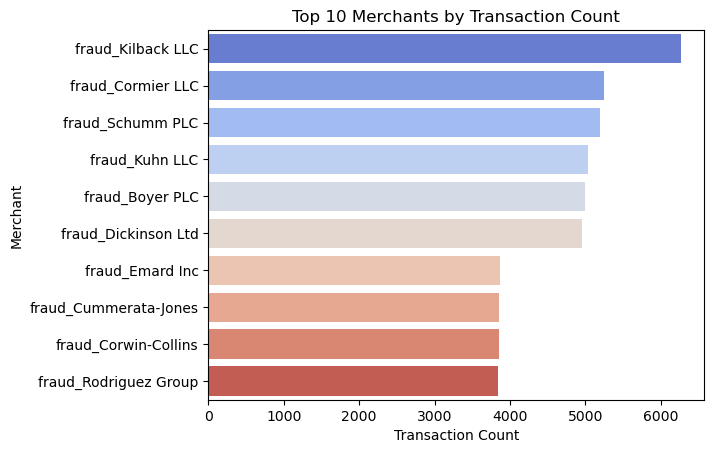

In [41]:
# bar plot of transaction counts by merchants
top_merchants = fraud['merchant'].value_counts().head(10)
sns.barplot(x=top_merchants.values, y=top_merchants.index,palette='coolwarm')
plt.title('Top 10 Merchants by Transaction Count')
plt.xlabel('Transaction Count')
plt.ylabel('Merchant')
plt.show()


In [42]:
# category unqiue values
print(len(fraud['category'].unique()))

14


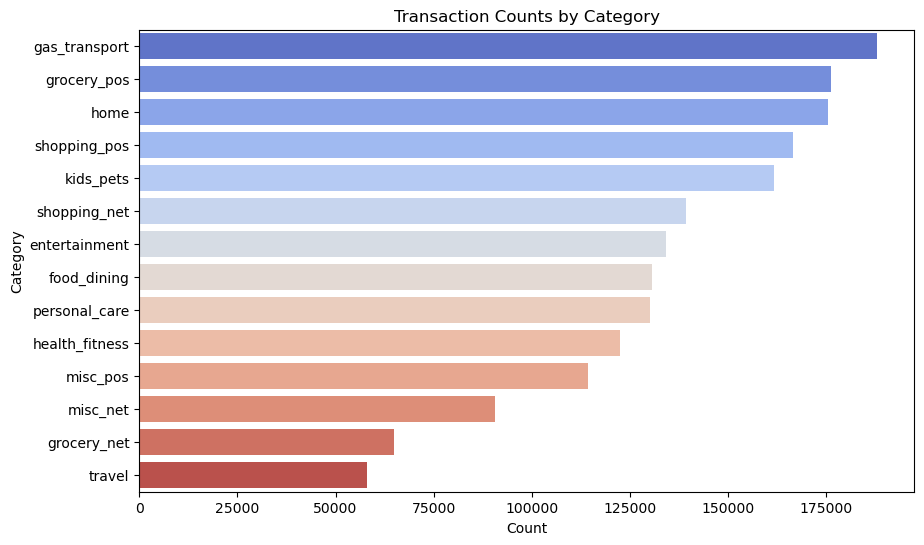

In [43]:
# bar plot of transaction counts by category
plt.figure(figsize=(10, 6))
sns.countplot(y='category', data=fraud, order = fraud['category'].value_counts().index,palette='coolwarm')
plt.title('Transaction Counts by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


In [44]:
# unique jobs
print(len(fraud['job'].unique()))

497


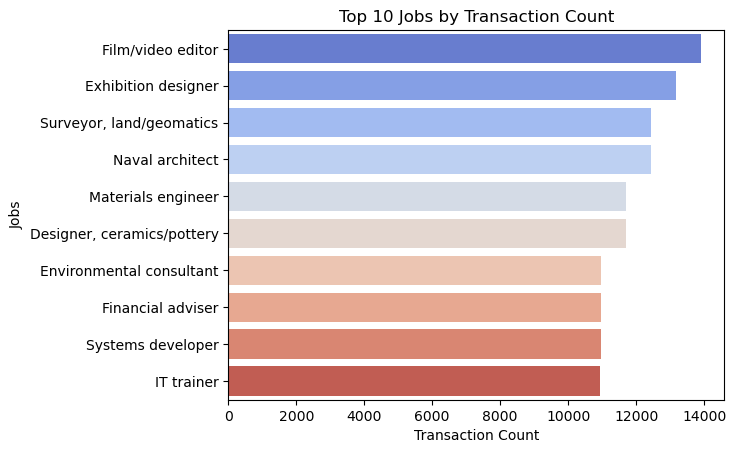

In [45]:
# bar plot of transaction counts by jobs 
top_jobs = fraud['job'].value_counts().head(10)
sns.barplot(x=top_jobs.values, y=top_jobs.index,palette='coolwarm')
plt.title('Top 10 Jobs by Transaction Count')
plt.xlabel('Transaction Count')
plt.ylabel('Jobs')
plt.show()


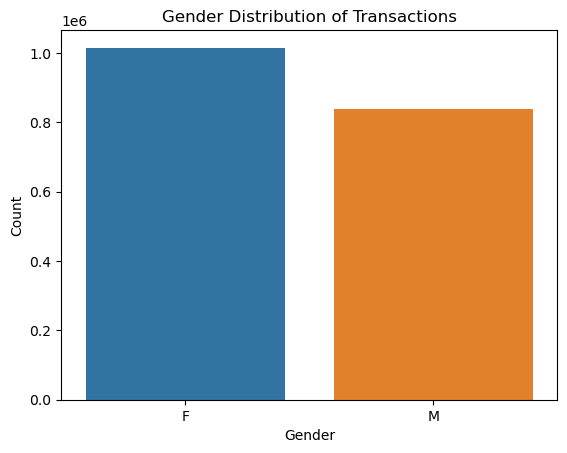

In [46]:
# bar plot of transaction counts by gender
sns.countplot(x='gender', data=fraud)
plt.title('Gender Distribution of Transactions')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


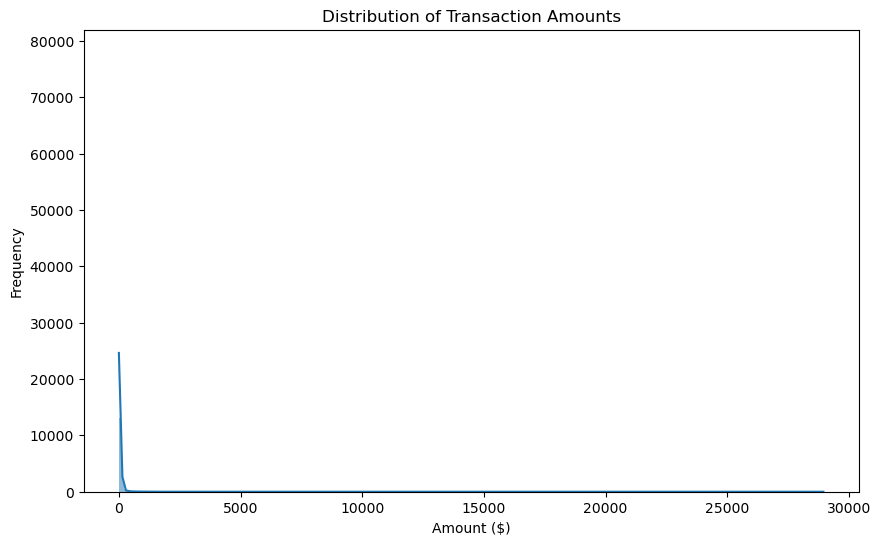

In [47]:
# distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(fraud['amt'], kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')
plt.show()


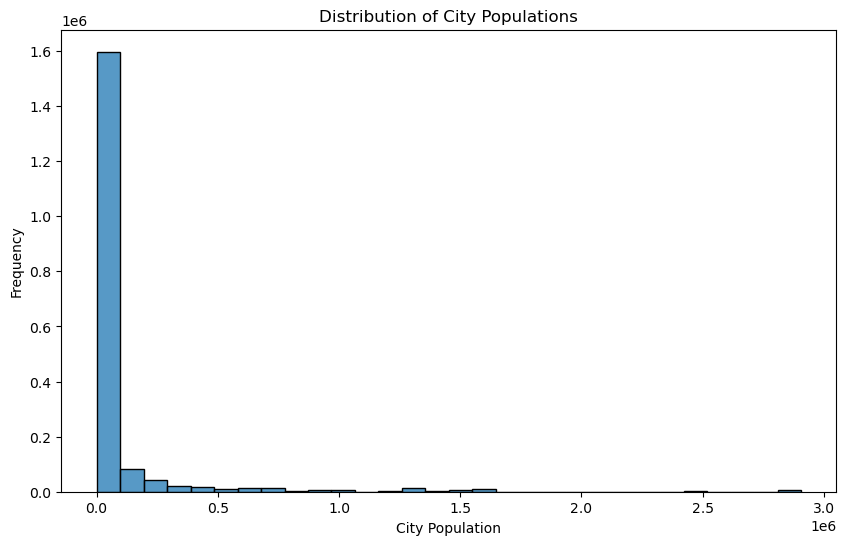

In [48]:
# distribution of city population for transactions
plt.figure(figsize=(10, 6))
sns.histplot(fraud['city_pop'], bins=30)
plt.title('Distribution of City Populations')
plt.xlabel('City Population')
plt.ylabel('Frequency')
plt.show()


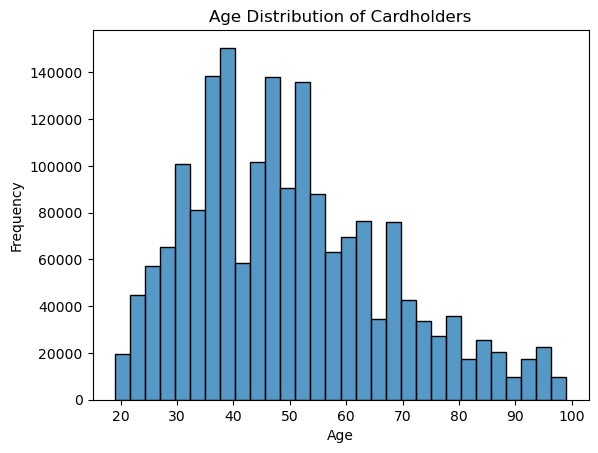

In [49]:
#Age distribution of cardholders
fraud['age'] = (pd.to_datetime('today') - fraud['dob']).dt.days // 365
sns.histplot(fraud['age'], bins=30)
plt.title('Age Distribution of Cardholders')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

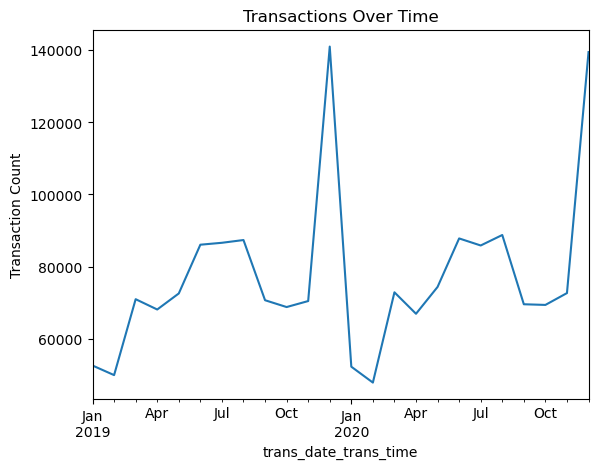

In [50]:
# Line plot for Transactions over time
fraud.set_index('trans_date_trans_time').resample('M').size().plot()
plt.ylabel('Transaction Count')
plt.title('Transactions Over Time')
plt.show()


**Exploring - What types of purchases are most likely to be instances of fraud?**

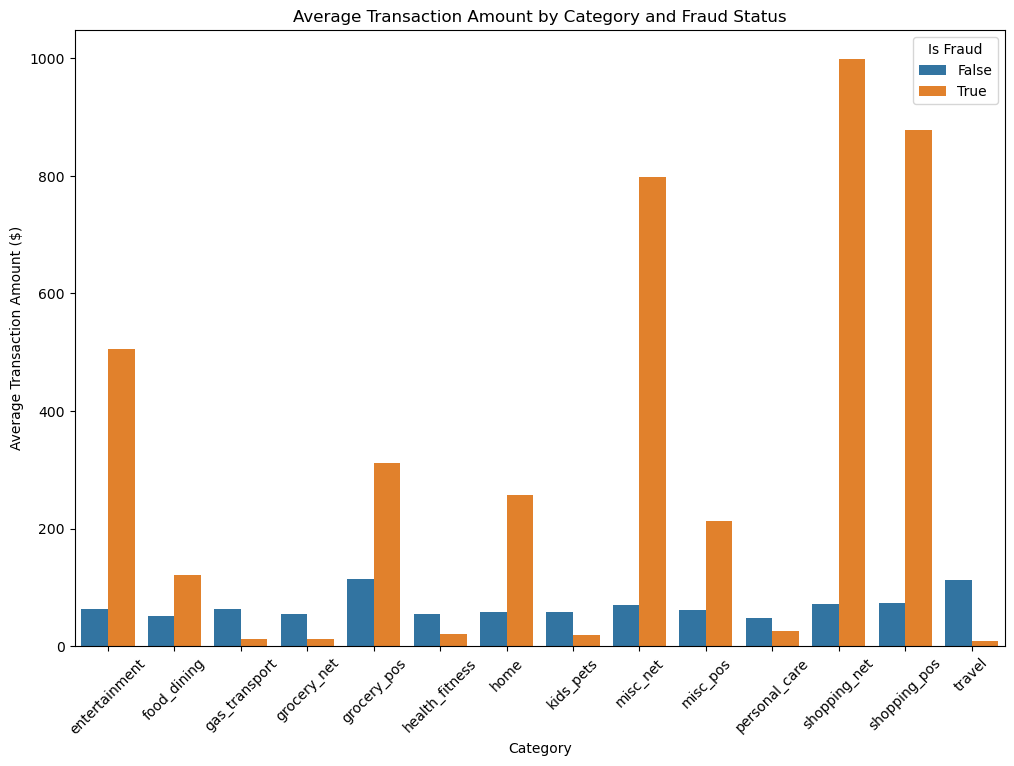

In [51]:
# Group by category and is_fraud, then calculate mean amount
fraud_by_category = fraud.groupby(['category', 'is_fraud'])['amt'].mean().unstack()

# Reset index to make 'category' a column again, helps in plotting
fraud_by_category.reset_index(inplace=True)


# Melt the DataFrame for easier plotting with seaborn
fraud_by_category = pd.melt(fraud_by_category, id_vars='category', value_vars=[False, True], var_name='is_fraud', value_name='mean_amt')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='category', y='mean_amt', hue='is_fraud', data=fraud_by_category)
plt.title('Average Transaction Amount by Category and Fraud Status')
plt.xticks(rotation=45)
plt.ylabel('Average Transaction Amount ($)')
plt.xlabel('Category')
plt.legend(title='Is Fraud')
plt.show()


**Visualizing - Fraud rates across different states using geospatial plot.**

In [52]:
# Calculate fraud rates
state_fraud_rates = fraud.groupby('state')['is_fraud'].mean().reset_index()
state_fraud_rates.rename(columns={'is_fraud': 'fraud_rate'}, inplace=True)

In [53]:
state_centers = {
    'AL': (32.806671, -86.791130), 'AK': (61.370716, -152.404419), 
    'AZ': (33.729759, -111.431221), 'AR': (34.969704, -92.373123), 
    'CA': (36.116203, -119.681564), 'CO': (39.059811, -105.311104), 
    'CT': (41.597782, -72.755371), 'DE': (39.318523, -75.507141), 
    'FL': (27.766279, -81.686783), 'GA': (33.040619, -83.643074), 
    'HI': (21.094318, -157.498337), 'ID': (44.240459, -114.478828), 
    'IL': (40.349457, -88.986137), 'IN': (39.849426, -86.258278), 
    'IA': (42.011539, -93.210526), 'KS': (38.526600, -96.726486), 
    'KY': (37.668140, -84.670067), 'LA': (31.169546, -91.867805), 
    'ME': (44.693947, -69.381927), 'MD': (39.063946, -76.802101), 
    'MA': (42.230171, -71.530106), 'MI': (43.326618, -84.536095), 
    'MN': (45.694454, -93.900192), 'MS': (32.741646, -89.678696), 
    'MO': (38.456085, -92.288368), 'MT': (46.921925, -110.454353), 
    'NE': (41.125370, -98.268082), 'NV': (38.313515, -117.055374), 
    'NH': (43.452492, -71.563896), 'NJ': (40.298904, -74.521011), 
    'NM': (34.840515, -106.248482), 'NY': (42.165726, -74.948051), 
    'NC': (35.630066, -79.806419), 'ND': (47.528912, -99.784012), 
    'OH': (40.388783, -82.764915), 'OK': (35.565342, -96.928917), 
    'OR': (44.572021, -122.070938), 'PA': (40.590752, -77.209755), 
    'RI': (41.680893, -71.511780), 'SC': (33.856892, -80.945007), 
    'SD': (44.299782, -99.438828), 'TN': (35.747845, -86.692345), 
    'TX': (31.054487, -97.563461), 'UT': (40.150032, -111.862434), 
    'VT': (44.045876, -72.710686), 'VA': (37.769337, -78.169968), 
    'WA': (47.400902, -121.490494), 'WV': (38.491226, -80.954570), 
    'WI': (44.268543, -89.616508), 'WY': (42.755966, -107.302490)
}


# Create a map centered on the US
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add circles for each state based on fraud rates
for state, coords in state_centers.items():
    # Find the fraud rate for the state, if it exists in your DataFrame
    fraud_rate = state_fraud_rates.loc[state_fraud_rates['state'] == state, 'fraud_rate'].values
    if fraud_rate.size >0:
        folium.Circle(
            location=coords,
            radius=np.sqrt(fraud_rate[0])*1000000, 
            color='crimson',
            fill=True,
            fill_color='crimson',
            fill_opacity=0.6,
            popup=f"{state}: {fraud_rate[0]*100}% Fraud Rate"
        ).add_to(m)

# Display the map
m


**Analyzing: Are older customers significantly more likely to be victims of credit card fraud?**

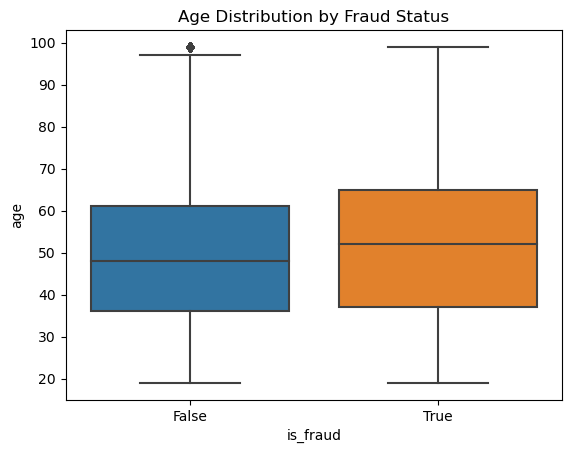

In [54]:
# splitting data (fraud & non-fraud)
fraud_group = fraud[fraud['is_fraud'] == 1]['age']
non_fraud_group = fraud[fraud['is_fraud'] == 0]['age']

# plotting boxplot
sns.boxplot(x='is_fraud', y='age', data=fraud)
plt.title('Age Distribution by Fraud Status')
plt.show()

In [55]:
# Let's do some statistical testing to check if the difference b/w groups is significant/not!
t_stat, p_value = ttest_ind(fraud_group, non_fraud_group, equal_var=False)
print(f"T-test P-value: {p_value}")


T-test P-value: 2.898800833531179e-45


**Feature Engineering**

In [56]:
#1. let's create a variable for distance b/w customer location and merchant location
fraud['distance_to_merchant'] = fraud.apply(lambda x: geodesic((x['lat'], x['long']), (x['merch_lat'], x['merch_long'])).miles, axis=1)
print(fraud['distance_to_merchant'].head(5))

0    48.947783
1    18.775736
2    67.172035
3    59.455974
4    48.282030
Name: distance_to_merchant, dtype: float64


In [57]:
#2. creating date & time features
fraud['transaction_hour'] = fraud['trans_date_trans_time'].dt.hour
fraud['transaction_day'] = fraud['trans_date_trans_time'].dt.day
fraud['transaction_month'] = fraud['trans_date_trans_time'].dt.month
fraud['transaction_year'] = fraud['trans_date_trans_time'].dt.year
fraud['weekday'] = fraud['trans_date_trans_time'].dt.weekday 

In [58]:
#3. To reduce cardinality lets map state to region
state_to_region = {
    'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast',
    'NJ': 'Northeast', 'NY': 'Northeast', 'PA': 'Northeast', 'RI': 'Northeast', 'VT': 'Northeast',
    'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest', 'KS': 'Midwest', 'MI': 'Midwest',
    'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest', 'ND': 'Midwest', 'OH': 'Midwest',
    'SD': 'Midwest', 'WI': 'Midwest',
    'AL': 'South', 'AR': 'South', 'DE': 'South', 'FL': 'South', 'GA': 'South',
    'KY': 'South', 'LA': 'South', 'MD': 'South', 'MS': 'South', 'NC': 'South',
    'OK': 'South', 'SC': 'South', 'TN': 'South', 'TX': 'South', 'VA': 'South',
    'WV': 'South',
    'AK': 'West', 'AZ': 'West', 'CA': 'West', 'CO': 'West', 'HI': 'West',
    'ID': 'West', 'MT': 'West', 'NV': 'West', 'NM': 'West', 'OR': 'West',
    'UT': 'West', 'WA': 'West', 'WY': 'West'
}
fraud['region'] = fraud['state'].map(state_to_region)

In [59]:
#4. grouping the labels for job due to high cardinality
category_keywords = {
    'Techincal, Engineering & Architecture': [
        'engineer', 'architect', 'surveyor', 'technologist', 'geologist', 
        'drafter', 'technician', 'planner'
    ],
    
    'IT & Technology': [
        'developer', 'programmer', 'analyst', 'data scientist', 'IT', 
        'sysadmin', 'network', 'software', 'technician'
    ],
    
    'Arts, Design & Media': [
        'designer', 'artist', 'illustrator', 'photographer', 'editor', 
        'producer', 'animator', 'writer', 'journalist', 'broadcaster', 
        'presenter', 'camera', 'copywriter', 'creative'
    ],
    
    'Management & Business': [
        'manager', 'officer', 'executive', 'administrator', 'consultant', 
        'director', 'strategist', 'planner', 'coordinator', 'secretary', 
        'chief', 'advisor'
    ],
    
    'Science & Research': [
        'scientist', 'researcher', 'biochemist', 'physicist', 'chemist', 
        'biologist', 'ecologist', 'lab technician', 'geophysicist', 
        'immunologist', 'pathologist'
    ],
    'Public Service & Security': [
        'police', 'firefighter', 'military', 'officer', 'guard', 'inspector', 
        'security', 'enforcement', 'detective', 'sergeant'
    ],
    
    'Finance & Accounting': [
        'accountant', 'auditor', 'financial', 'banker', 'investor', 'tax', 
        'treasurer', 'controller', 'broker', 'actuary'
    ],
    
    'Human Resources': [
        'HR', 'recruiter', 'talent'
    ],
    'Sales & Marketing': [
        'sales', 'marketer', 'advertiser', 'promoter', 'SEO'
    ],
    
    'Construction & Manual Work': [
        'builder', 'constructor', 'mechanic', 'electrician', 'plumber', 
        'carpenter', 'mason', 'welder', 'technician', 'landscaper'
    ],
    
    'Hospitality & Tourism': [
        'chef', 'cook', 'hotel', 'tourism', 'guide', 'catering', 'restaurateur', 
        'barista', 'bartender','brewer'
    ],
    
    'Transport & Logistics': [
        'driver', 'pilot', 'navigator', 'logistics', 'supply chain', 'courier', 
        'dispatcher', 'freight', 'transport'
    ],
    
    'Museum & Cultural Services': [
        'curator', 'archivist', 'conservator', 'museum', 'gallery'
    ],
    
    'Legal & Paralegal Services': [
        'barrister', 'licensed conveyancer', 'loss adjuster', 'solicitor', 'legal', 'attorney', 'lawyer', 'paralegal','counsel'
    ],
    
    'Environmental Services': [
        'hydrologist', 'ecologist', 'environmental consultant', 'geologist', 'meteorologist'
    ],
    
    'Science & Laboratory Services': [
        'cytogeneticist', 'biochemist', 'field seismologist', 'metallurgist', 
        'laboratory', 'research associate', 'scientist'
    ],
    
    'Public Services & Administration': [
        'civil service', 'public', 'administrator', 'clerk', 'government'
    ],
    
    'Education & Training': [
         'adviser', 'trainer','teacher', 'educator', 'lecturer', 'professor', 'instructor', 'librarian', 'tutor'
    ],
    
    'Healthcare, Safety & Medical Services': [
        'nurse', 'doctor', 'psychologist', 'therapist', 'radiographer', 
        'physiotherapist', 'pharmacist', 'paramedic', 'clinician', 'surgeon', 
        'medical', 'health', 'podiatrist', 'chiropodist', 'osteopath','hygienist', 'safety', 'occupational health'
    ],
    
    'Retail & Customer Service': [
        'retail', 'merchandiser', 'customer service', 'dealer', 'buyer', 'shop assistant'
    ],
    
    'Miscellaneous': [
        'gaffer', 'barrister’s clerk', 'aid worker', 'comptroller', 'sub', 'make', 'land'
    ]
}


In [60]:
def assign_category(job_title, category_keywords):
    for category, keywords in category_keywords.items():
        if any(keyword.lower() in job_title.lower() for keyword in keywords):
            return category
    return 'Miscellaneous'  

# Applying the categorization
fraud['job_category'] = fraud['job'].apply(lambda x: assign_category(x, category_keywords))

# Review the distribution of the job categories
print(fraud['job_category'].value_counts())

job_category
Techincal, Engineering & Architecture    347663
Management & Business                    290042
IT & Technology                          262681
Miscellaneous                            190924
Healthcare, Safety & Medical Services    180755
Science & Research                       143328
Arts, Design & Media                     106939
Education & Training                      90046
Legal & Paralegal Services                57808
Finance & Accounting                      55615
Retail & Customer Service                 27088
Public Service & Security                 26319
Science & Laboratory Services             17563
Transport & Logistics                     13164
Public Services & Administration          12445
Museum & Cultural Services                11729
Hospitality & Tourism                      8769
Sales & Marketing                          7309
Environmental Services                     2207
Name: count, dtype: int64


**Preprocessing**

In [61]:
# removing unnecessary(irrelevant) columns & some original columns post feature engineering

#irrelevant - 'cc_num', 'trans_num', 'first', 'last','city','street','zip', 'merchant','unix_time'
#original cols post FE - 'state','dob','job','lat', 'long', 'merch_lat', 'merch_long', 'trans_date_trans_time'

cols_drop = ['cc_num', 'trans_num', 'first', 'last', 'state','city','street','zip', 'merchant',
                      'unix_time','dob','job','lat', 'long', 'merch_lat', 'merch_long', 'trans_date_trans_time']
fraud = fraud.drop(columns=cols_drop)

In [62]:
#converting categoricals to dummy
categorical_cols = fraud.select_dtypes(include=['object', 'category']).columns.tolist()
fraud = pd.get_dummies(fraud, columns=categorical_cols, drop_first=True)

In [63]:
#looking at the final data
fraud.head(5)

,amt,city_pop,is_fraud,age,distance_to_merchant,transaction_hour,transaction_day,transaction_month,transaction_year,weekday,...,job_category_Miscellaneous,job_category_Museum & Cultural Services,job_category_Public Service & Security,job_category_Public Services & Administration,job_category_Retail & Customer Service,job_category_Sales & Marketing,job_category_Science & Laboratory Services,job_category_Science & Research,"job_category_Techincal, Engineering & Architecture",job_category_Transport & Logistics
0,4.97,3495,False,36,48.947783,0,1,1,2019,1,...,False,False,False,False,False,False,False,False,False,False
1,107.23,149,False,45,18.775736,0,1,1,2019,1,...,False,False,False,False,False,False,False,False,False,False
2,220.11,4154,False,62,67.172035,0,1,1,2019,1,...,False,False,False,False,False,False,False,False,False,False
3,45.00,1939,False,57,59.455974,0,1,1,2019,1,...,False,False,False,False,False,False,False,False,False,False
4,41.96,99,False,38,48.282030,0,1,1,2019,1,...,False,False,False,False,False,False,False,False,False,False


In [64]:
# separating features and target
X = fraud.drop('is_fraud',axis=1)
y = fraud['is_fraud'].values

In [65]:
# Standard scaling
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)

In [66]:
# Random under sampling on entire data
rus = RandomUnderSampler(random_state=111)
x_sample,y_sample = rus.fit_resample(X_scaled,y)
print(f"Size of features data after applying Random Under Sampling Technqiue: {x_sample.shape}")
print(f"Distribution of target variable:  {np.bincount(y_sample)}")
        

Size of features data after applying Random Under Sampling Technqiue: (19302, 44)
Distribution of target variable:  [9651 9651]


**Train Scikit Models**

In [67]:
#Setup Crossval classifier scorers
scorers = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1': 'f1'
}
rand_st = 111 # random seed

In [68]:
#Logistic regression
start_ts = time.time()
'''change the solver value to: 'lbfgs','liblinear','sag',or'newton-cg' to examine how it effects the metrics of the model.'''
clf = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000,class_weight=None,random_state=rand_st) 
scores = cross_validate(estimator=clf, X=x_sample, y=y_sample, scoring=scorers, cv=5)

# Print the scores
print("Logistic Regression Metrics:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))
print("CV Runtime:", time.time() - start_ts)


Logistic Regression Metrics:
Accuracy: 0.81 (+/- 0.02)
Precision: 0.86 (+/- 0.03)
Recall: 0.74 (+/- 0.06)
F1: 0.79 (+/- 0.03)
CV Runtime: 0.7343382835388184


In [69]:
# Support Vector Machine                                                                                                                
start_ts=time.time()
'''change the kernel value to: 'linear','poly','rbf' to examine how it effects the metrics of the model.'''
clf=SVC(kernel='linear',gamma='scale',C=1.0,probability=False,random_state=rand_st) # using default paramaters
scores=cross_validate(estimator=clf,X=x_sample, y=y_sample,scoring=scorers,cv=5)

# Print the scores
print("Support Vector Machine Metrics:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))
print("CV Runtime:", time.time() - start_ts)


Support Vector Machine Metrics:
Accuracy: 0.86 (+/- 0.01)
Precision: 0.95 (+/- 0.01)
Recall: 0.75 (+/- 0.03)
F1: 0.84 (+/- 0.02)
CV Runtime: 187.33595037460327


In [70]:
# K-Nearest Neighbors
start_ts = time.time()
'''change the neighbors value b/w 5 to 25 to examine how it effects the metrics of the model.'''
clf = KNeighborsClassifier(n_neighbors=25, weights='uniform', algorithm='auto', p=2, metric='minkowski') # using default paramaters
scores = cross_validate(estimator=clf, X=x_sample, y=y_sample, scoring=scorers, cv=5)

# Print the scores
print("K-Nearest Neighbors Metrics:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))
print("CV Runtime:", time.time() - start_ts)

K-Nearest Neighbors Metrics:
Accuracy: 0.81 (+/- 0.02)
Precision: 0.87 (+/- 0.02)
Recall: 0.74 (+/- 0.05)
F1: 0.80 (+/- 0.03)
CV Runtime: 3.4014997482299805


In [71]:
# Decision trees
start_ts=time.time()
'''change the criterion value to 'entropy'/'gini' to examine how it effects the metrics of the model.'''
clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st) # using default paramaters
scores = cross_validate(estimator=clf, X=x_sample, y=y_sample, scoring=scorers, cv=5)

# Print the scores
print("Decision Tree Metrics:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))
print("CV Runtime:", time.time() - start_ts)

Decision Tree Metrics:
Accuracy: 0.93 (+/- 0.07)
Precision: 0.97 (+/- 0.01)
Recall: 0.89 (+/- 0.14)
F1: 0.92 (+/- 0.08)
CV Runtime: 1.4106132984161377


In [72]:
# Random Forest
start_ts=time.time()
'''change the  estimators b/w 10 to 500 to examine how it effects the metrics of the model.'''
clf = RandomForestClassifier(n_estimators=500,criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st) # using default paramaters
scores = cross_validate(estimator=clf, X=x_sample, y=y_sample, scoring=scorers, cv=5)

# Print the scores
print("Random Forest Metrics:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))
print("CV Runtime:", time.time() - start_ts)

Random Forest Metrics:
Accuracy: 0.96 (+/- 0.07)
Precision: 0.97 (+/- 0.01)
Recall: 0.94 (+/- 0.13)
F1: 0.95 (+/- 0.08)
CV Runtime: 449.3473825454712


In [73]:
# Gradient Boosting
start_ts=time.time()
'''change the max_depth value b/w 3 to 11 to examine how it effects the metrics of the model.'''
clf=GradientBoostingClassifier(n_estimators=100,loss='log_loss',learning_rate=0.1,max_depth=11,min_samples_split=2,random_state=rand_st) # using default paramaters
scores=cross_validate(estimator=clf, X=x_sample, y=y_sample, scoring=scorers, cv=5) 

# Print the scores
print("Gradient Boosting Metrics:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))
print("CV Runtime:", time.time() - start_ts)


Gradient Boosting Metrics:
Accuracy: 0.95 (+/- 0.07)
Precision: 0.98 (+/- 0.01)
Recall: 0.93 (+/- 0.14)
F1: 0.95 (+/- 0.08)
CV Runtime: 186.93014883995056


In [74]:
# MLP
start_ts=time.time()
'''change the solver to: 'lbfgs','adam' or 'sgd' to examine the effects on the metrics.'''
clf=MLPClassifier(activation='relu',solver='sgd',alpha=0.0001,hidden_layer_sizes=(100,),random_state=rand_st) # using default paramaters
scores=cross_validate(estimator=clf, X=x_sample, y=y_sample, scoring=scorers, cv=5) 

# Print the scores
print("MLP Metrics:")
for metric in scorers.keys():
    print(f"{metric}: %0.2f (+/- %0.2f)" % (scores[f'test_{metric}'].mean(), scores[f'test_{metric}'].std() * 2))
print("CV Runtime:", time.time() - start_ts)                                                                                                                     

C:\Users\Shanmukhi B\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Shanmukhi B\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Shanmukhi B\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Shanmukhi B\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Metrics:
Accuracy: 0.87 (+/- 0.04)
Precision: 0.92 (+/- 0.01)
Recall: 0.81 (+/- 0.08)
F1: 0.86 (+/- 0.05)
CV Runtime: 137.42032480239868


C:\Users\Shanmukhi B\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**Comparision between models**

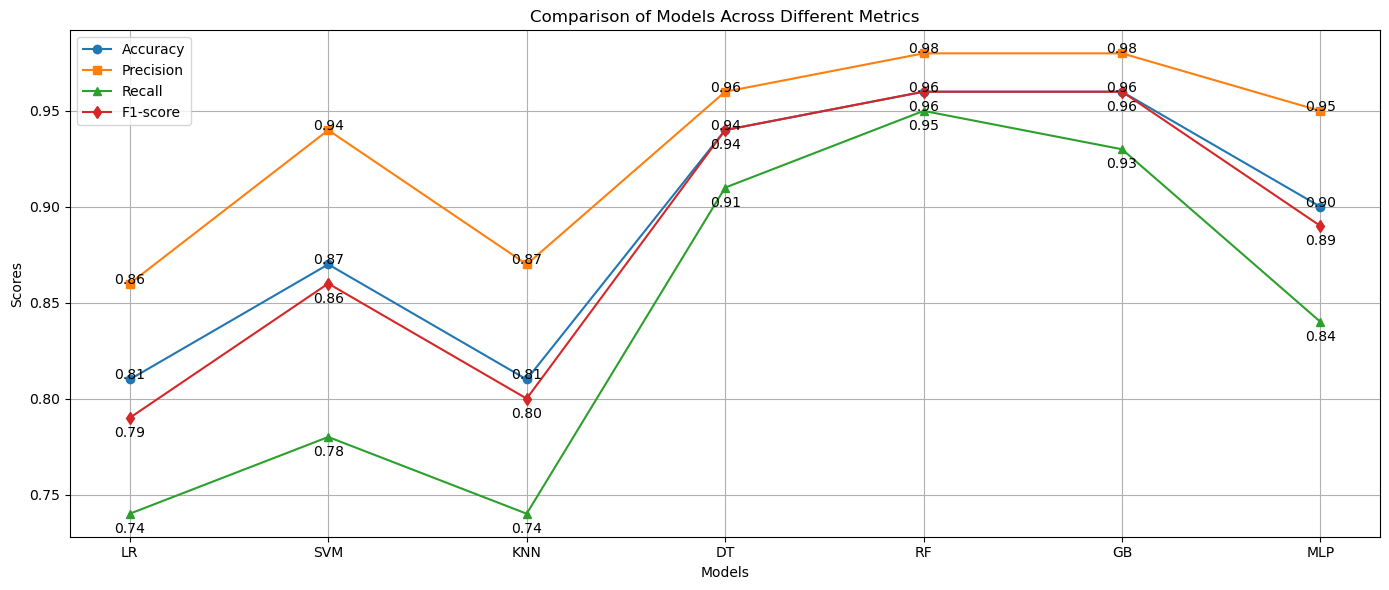

In [75]:
# Let's create a line plot that compares all models across multiple metrics.

# Sample data for the models (considering values from parameters with high recall)
models = ['LR', 'SVM', 'KNN', 'DT', 'RF', 'GB','MLP']
model_index = np.arange(len(models))
accuracy = [0.81, 0.87, 0.81, 0.94, 0.96, 0.96,0.90]
precision = [0.86, 0.94, 0.87, 0.96, 0.98, 0.98,0.95]
recall = [0.74, 0.78, 0.74, 0.91, 0.95, 0.93,0.84]
f1_score = [0.79, 0.86, 0.80, 0.94, 0.96, 0.96,0.89]

fig, ax = plt.subplots(figsize=(14, 6))

# Plotting each metric
ax.plot(models, accuracy, '-o', label='Accuracy')
ax.plot(models, precision, '-s', label='Precision')
ax.plot(models, recall, '-^', label='Recall')
ax.plot(models, f1_score, '-d', label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models Across Different Metrics')
ax.legend()

# Adding the text labels on each marker
for i in range(len(models)):
    ax.text(i, accuracy[i] + 0.00, f'{accuracy[i]:.2f}', ha = 'center')
    ax.text(i, precision[i] + 0.00, f'{precision[i]:.2f}', ha = 'center')
    ax.text(i, recall[i] - 0.01, f'{recall[i]:.2f}', ha = 'center')
    ax.text(i, f1_score[i] - 0.01, f'{f1_score[i]:.2f}', ha = 'center')

# Show grid
ax.grid(True)

plt.tight_layout()
plt.show()


**Feature Importance**

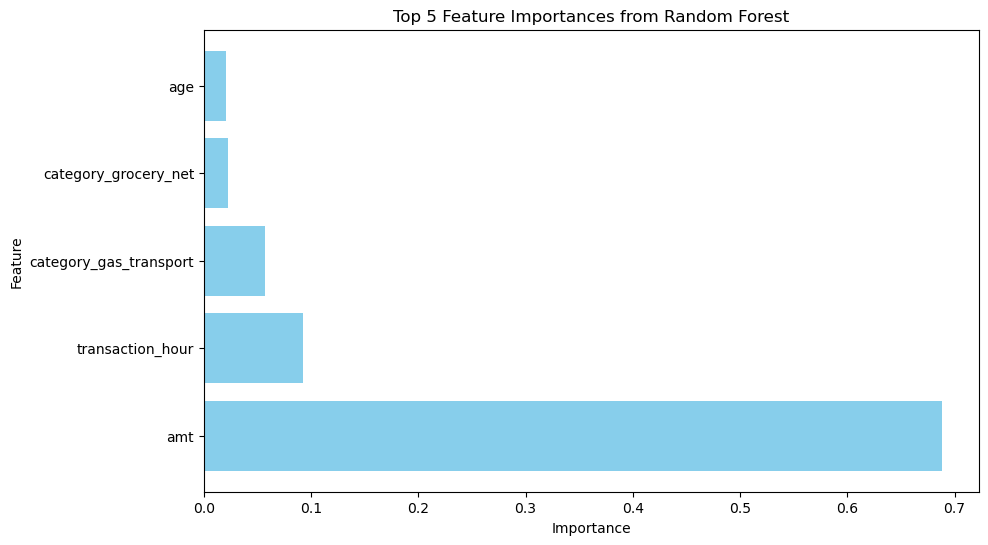

In [81]:
# Random Forest with 20 estimators - better model among all with good amount of recall

clf = RandomForestClassifier(n_estimators=20,criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st) # using default paramaters
clf.fit(x_sample, y_sample)
feature_importances = clf.feature_importances_

# Create a DataFrame for feature importances for visualization
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Select the top 5 features
top_features = features_df.head(5)

# # Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importances from Random Forest')
plt.show()